## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Retrieve Images

In [3]:
def getImagesFromDirectory(directory):
    images = []   
    for imageFile in os.listdir(directory):
        if not imageFile[0] == '.':
            images.append(mpimg.imread(directory + '/' + imageFile))   
    return images

def displayImages(images):
    for image in images:
        displayImage(image)

def displayImage(image):
    plt.figure()
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

In [4]:
calibrationImages = getImagesFromDirectory('camera_cal')
testImages = getImagesFromDirectory('test_images')

In [5]:
#displayImages(calibrationImages)
#displayImages(testImages)

## Calibrate Camera

In [6]:
# get the chessboard corners

singleObjectPoints = np.zeros((6*9,3), np.float32)
singleObjectPoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objectPoints = []
imagePoints = []
boardsWithPoints = []

for image in calibrationImages:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imagePoints.append(corners)
        objectPoints.append(singleObjectPoints)
        #boardsWithPoints.append(cv2.drawChessboardCorners(image, (9,6), corners, ret))
        
#displayImages(boardsWithPoints)

In [7]:
# use the chessboard corners to calculate the calibration matrix

shape = calibrationImages[0].shape
shape = (shape[1], shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, shape, None, None)

def undistortImage(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)


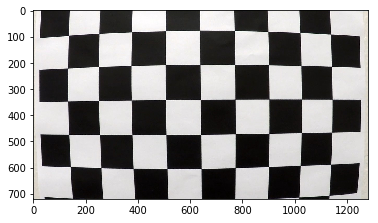

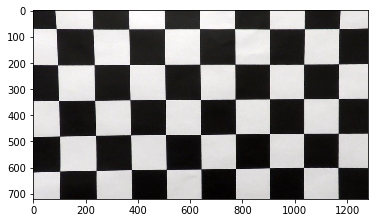

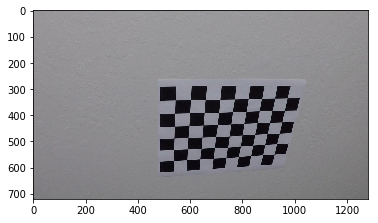

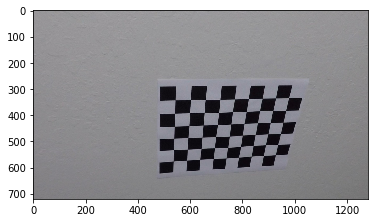

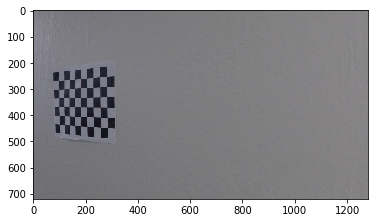

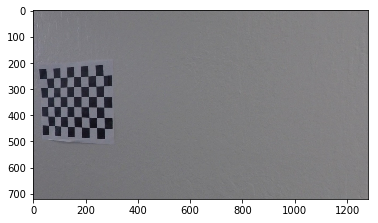

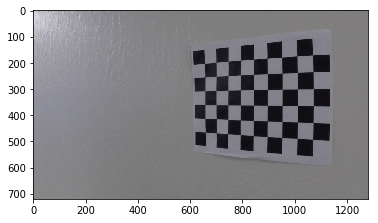

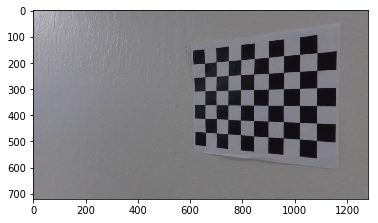

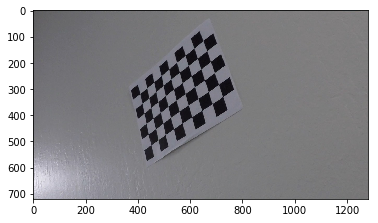

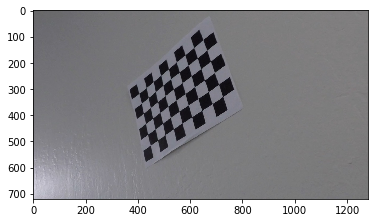

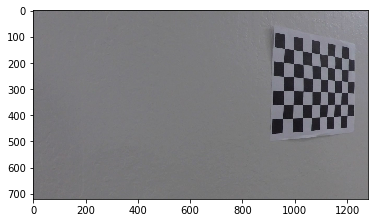

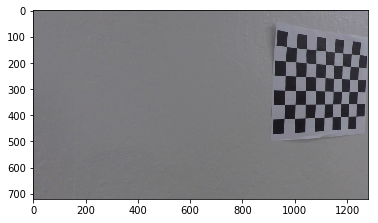

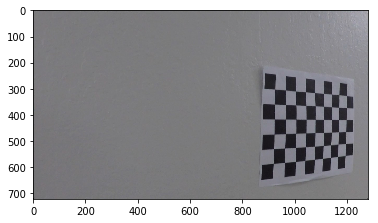

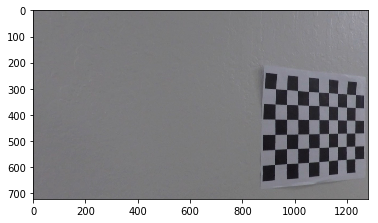

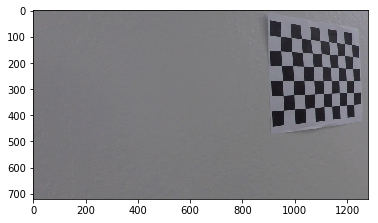

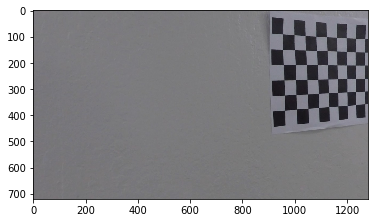

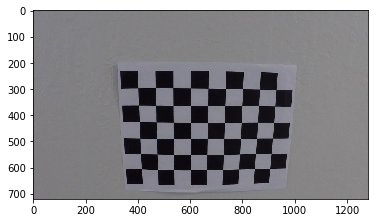

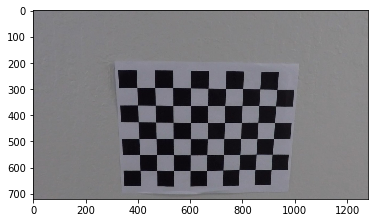

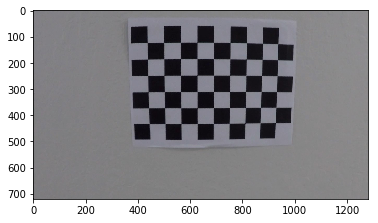

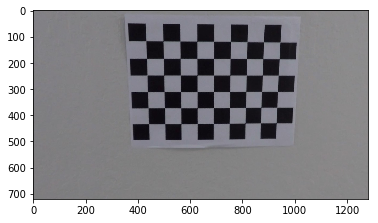

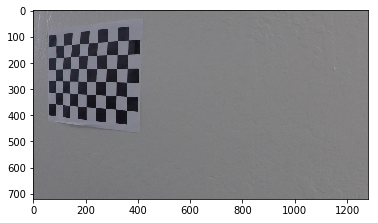

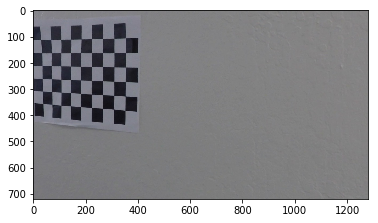

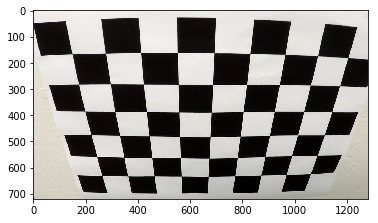

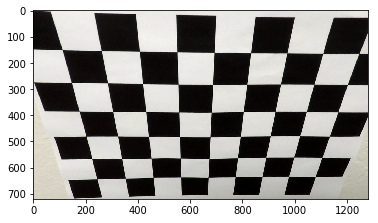

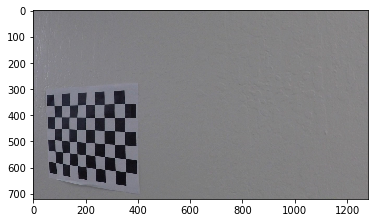

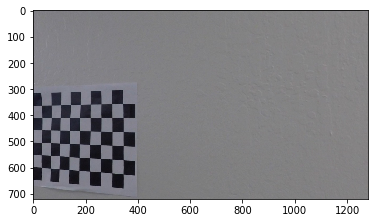

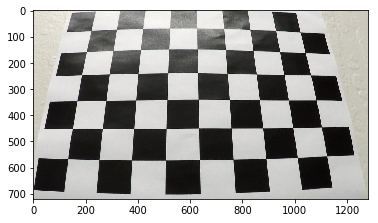

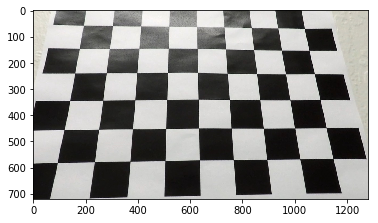

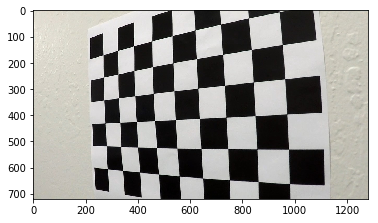

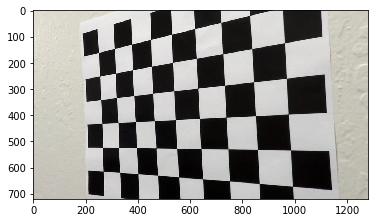

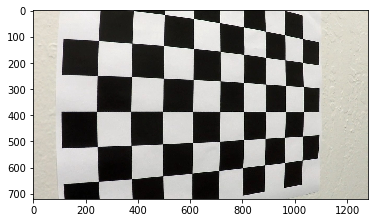

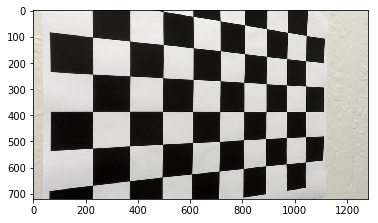

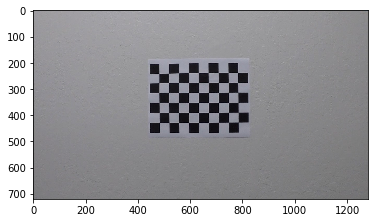

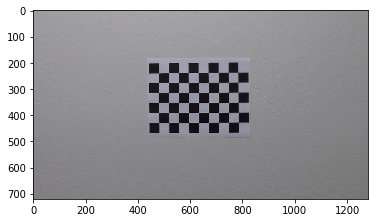

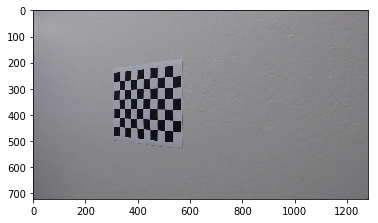

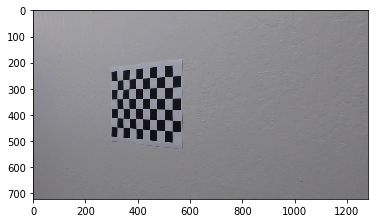

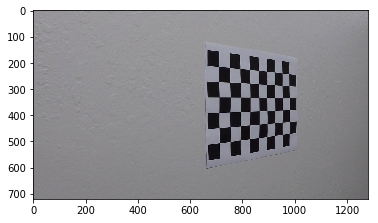

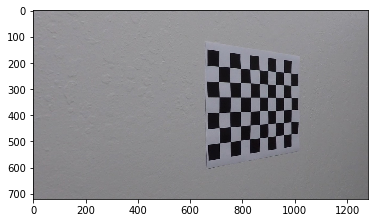

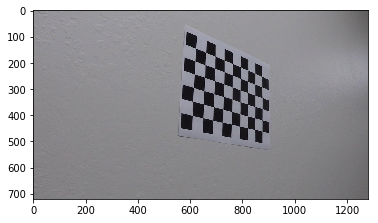

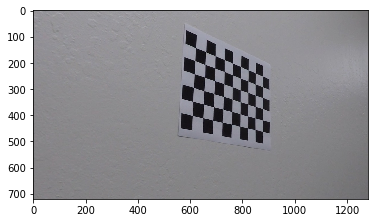

In [8]:
# view the before and after to compare

for image in calibrationImages:
    displayImage(image)
    displayImage(undistortImage(image, mtx, dist))

## Pipeline

In [9]:
# not part of the pipeline, but useful for debugging

def displayCombinedBinary(image1, image2):
    color_binary = np.dstack(( np.zeros_like(image1), image1, image2)) * 255
    displayImage(color_binary)
    
def printText(image, text, yPosition):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,yPosition)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 3

    cv2.putText(image, text, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)

### Gradient and S channel thresholding

In [10]:
def sobel(image, axis, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if axis == "y":
        x=0
        y=1
    else:
        x=1
        y=0
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    abs_sobel = np.absolute(sobel)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    return thresholdArray(scaled_sobel, threshold)
    
def thresholdArray(array, threshold):
    outputArray = np.zeros_like(array)
    outputArray[(array >= threshold[0]) & (array <= threshold[1])] = 1
    return outputArray

def s_channel(image, threshold):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    scaled_s_channel=np.uint8(255*(s_channel/np.max(s_channel)))
    return thresholdArray(scaled_s_channel, threshold)
    
def combineBinaries(image1, image2):
    combined = np.zeros_like(image1)
    combined[(image1 == 1) | (image2 == 1)] = 1
    return combined
    
def thresholdImage(image, debug = False):
    sobelX = sobel(image, "x", (30,100))
    s = s_channel(image, (170, 255))
    if debug:
        displayImage(sobelX)
        displayImage(s)
        if (tooMuchNoise(s)):
            print("s is too noisy")
        displayCombinedBinary(sobelX, s)
        
    if tooMuchNoise(s):
        outputImage = sobelX
    else:
        outputImage = combineBinaries(sobelX, s)
        
    return outputImage

def tooMuchNoise(image, threshold = 30):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    return histogram[midpoint] > threshold
        

In [ ]:
image = testImages[4]
image = s_channel(image, (170, 255))
displayImage(image)

histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
midpoint = np.int(histogram.shape[0]//2)

print(np.argmax(histogram))
print(histogram[midpoint])
print(np.argmax(histogram[:midpoint]))
print(np.argmax(histogram[midpoint:])+midpoint)

### Perspective Transform

In [36]:
def sourcePoints():
    return np.float32([
        (249, 688),   #bottom left
        (595, 451),   #top left
        (685, 451),   #top right
        (1059, 688)]) #bottom right

def destinationPoints():
    x_offset = 300
    image_size = (image.shape[1], image.shape[0])
    return np.float32([ 
        [x_offset, image_size[1]], #bottom left
        [x_offset, 0],   #top left
        [image_size[0]-x_offset, 0], #top right
        [image_size[0]-x_offset, image_size[1]] #bottom right
        ])

def getPerspectiveMatrices():
    source = sourcePoints()
    destination = destinationPoints()
    forwardMatrix = cv2.getPerspectiveTransform(source, destination)
    inverseMatrix = cv2.getPerspectiveTransform(destination, source)
    return (forwardMatrix, inverseMatrix)

def shiftPerspective(image, matrix):
    image_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, matrix, image_size, flags=cv2.INTER_LINEAR)
    return warped

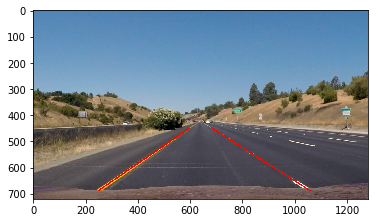

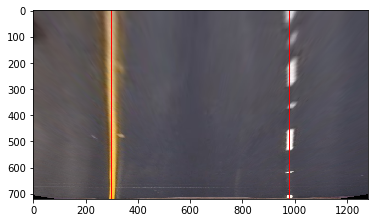

In [38]:
# display images with lines drawn before and after transform

testImages = getImagesFromDirectory('test_images')
image = testImages[0]

source = sourcePoints()
cv2.line(image, (source[0][0], source[0][1]), (source[1][0], source[1][1]), [255, 0, 0], 4)
cv2.line(image, (source[2][0], source[2][1]), (source[3][0], source[3][1]), [255, 0, 0], 4)
displayImage(image)


testImages = getImagesFromDirectory('test_images')
image = testImages[0]

perspectiveMatrix, inverseMatrix = getPerspectiveMatrices()
image = shiftPerspective(image, perspectiveMatrix)

destination = destinationPoints()
cv2.line(image, (destination[0][0], destination[0][1]), (destination[1][0], destination[1][1]), [255, 0, 0], 4)
cv2.line(image, (destination[2][0], destination[2][1]), (destination[3][0], destination[3][1]), [255, 0, 0], 4)  
displayImage(image)


## Identify Lines

### Define Line Class

In [21]:
class Line():
    def __init__(self, side):
        self.detectedInPrevFrame = False  
        self.current_fit = [np.array([False])]  
        self.prev_fit = [np.array([False])]
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        self.allx = None  
        self.ally = None
        
        if side == 'left':
            self.left = True
        if side == 'right':
            self.left = False
        
        self.windows = []
        self.margin = 100
    
    def findLine(self, image):
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        self.windows = []
        self.prev_fit = self.current_fit
        
        if self.detectedInPrevFrame:
            lane_pixel_indices = self.findLanePointsFromFit(self.current_fit, nonzeroy, nonzerox)
        else:
            lane_pixel_indices = self.findLanePointsInWindows(image, nonzeroy, nonzerox)
        
        self.allx = nonzerox[lane_pixel_indices]
        self.ally = nonzeroy[lane_pixel_indices]
        self.current_fit = np.polyfit(self.ally, self.allx, 2)
        
        self.detectedInPrevFrame = True
        
        return
        
    def findLanePointsFromFit(self, fit, nonzeroy, nonzerox):
        lane_pixel_indices = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - self.margin)) 
                              & (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + self.margin)))
        return lane_pixel_indices
        
    def findLanePointsInWindows(self, image, nonzeroy, nonzerox):
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
        midpoint = np.int(histogram.shape[0]//2)
        if self.left:
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint
        
        num_windows = 9
        window_height = np.int(image.shape[0]//num_windows)
        
        x_current = x_base
        minpix = 50
        
        lane_pixel_indices = []
        
        for window in range(num_windows):
            # Identify window boundaries in x and y
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            win_x_low = x_current - self.margin
            win_x_high = x_current + self.margin
            
            self.windows.append([(win_x_low, win_y_low),(win_x_high, win_y_high)])
            
            # Identify the nonzero pixels in x and y within the window
            good_pixels = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            
            # Append these indices to the lists
            lane_pixel_indices.append(good_pixels)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_pixels) > minpix:
                x_current = np.int(np.mean(nonzerox[good_pixels]))
        
        return np.concatenate(lane_pixel_indices)
    
    def drawLine(self, image):
        if len(image.shape) == 2:
            out_img = np.dstack((image, image, image))*255
        else:
            out_img = image
            
        # color points on the output image
        if self.left:
            color = [255, 0, 0]
        else:
            color = [0, 0, 255]
        out_img[self.ally, self.allx] = color

        # plot the fits on the output image
        points = []
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]

        for i in range(len(ploty)):
            points.append([int(round(fitx[i])),int(ploty[i])])

        cv2.polylines(out_img, np.int32([points]), False, [255, 255, 255])
        
        if len(self.windows)>0:
            out_img = self.drawWindowBoxes(out_img)
        else:
            out_img = self.drawFitWindow(out_img, ploty)
        
        return out_img
    
    def drawWindowBoxes(self, out_img):
        for window in self.windows:
                cv2.rectangle(out_img, window[0], window[1], (0,255,0), 2)
        
        return out_img
    
    def drawFitWindow(self, out_img, ploty):
        window_image = np.zeros_like(out_img)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        fitx = self.prev_fit[0]*ploty**2 + self.prev_fit[1]*ploty + self.prev_fit[2]
        line_window1 = np.array([np.transpose(np.vstack([fitx-self.margin, ploty]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+self.margin, ploty])))])
        line_pts = np.hstack((line_window1, line_window2))

        cv2.fillPoly(window_image, np.int_([line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_image, 0.3, 0)
        return out_img

In [22]:
def identifyLines(image, leftLine, rightLine):
    
    leftLine.findLine(image)
    rightLine.findLine(image)
    
    out_image = rightLine.drawLine(image)
    out_image = leftLine.drawLine(out_image)
    
    return out_image

In [53]:
def addLinesToOriginalImage(image, leftLine, rightLine):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fit = leftLine.current_fit
    right_fit = rightLine.current_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    points = []
    for i in range(len(ploty)):
        points.append([int(round(left_fitx[i])),int(ploty[i])])
    for i in range(len(ploty)-1, -1, -1):
        points.append([int(round(right_fitx[i])),int(ploty[i])])

    lanes = np.zeros_like(image)
    cv2.fillConvexPoly(lanes, np.array(points), 255)
    lanes = shiftPerspective(lanes,inverseMatrix)
    
    return cv2.addWeighted(image, .8, lanes, .2, 0)

## Calculate curvature

In [24]:
def calcCurvature(line):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(line.ally*ym_per_pix, line.allx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval = image.shape[0]-1
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    return curverad

## Pipeline definition

In [55]:
perspectiveMatrix, inverseMatrix = getPerspectiveMatrices()

def imagePipeline(image, debug = False, resetLines = False):
    global leftLine
    global rightLine
    if resetLines:
        leftLine = Line('left')
        rightLine = Line('right')
        
    outputImage = undistortImage(image, mtx, dist)
    if debug:
        displayImage(outputImage)
    
    outputImage = thresholdImage(outputImage)
    if debug:
        displayImage(outputImage)
    
    outputImage = shiftPerspective(outputImage, perspectiveMatrix)
    if debug:
        displayImage(outputImage)
    
    outputImage = identifyLines(outputImage, leftLine, rightLine)
    if debug:
        displayImage(outputImage)
        
    leftCurve = calcCurvature(leftLine)
    rightCurve = calcCurvature(rightLine)
    
    outputImage = addLinesToOriginalImage(image, leftLine, rightLine)
    printText(outputImage, 'left: ' + str(round(leftCurve)), 70)
    printText(outputImage, 'right: ' + str(round(rightCurve)), 130)
    
    if len(outputImage.shape) == 2:
        # if it's gray, make it a 3 channel image for the video formatting
        outputImage = np.dstack((outputImage, outputImage, outputImage)) * 255
        
    return outputImage


## Test Images

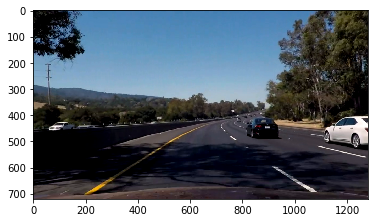

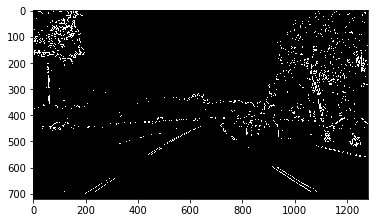

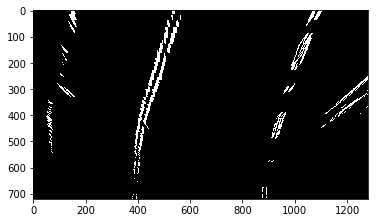

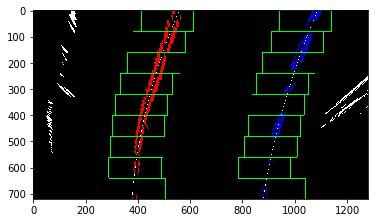

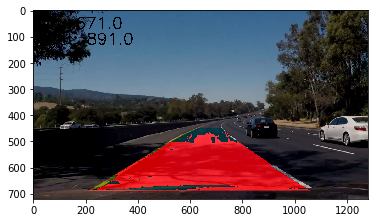

In [29]:
testImages = getImagesFromDirectory('video_frames')
displayImage(imagePipeline(testImages[0], resetLines=True, debug=True))

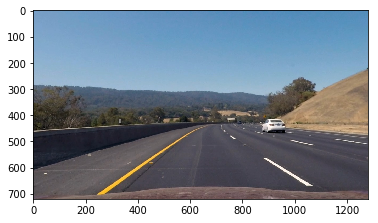

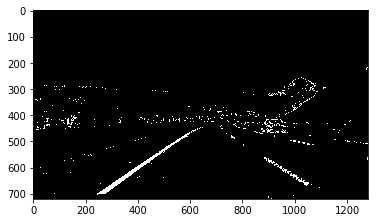

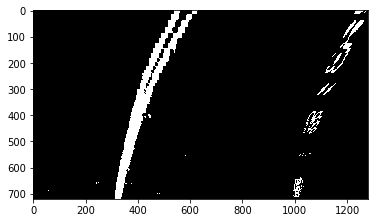

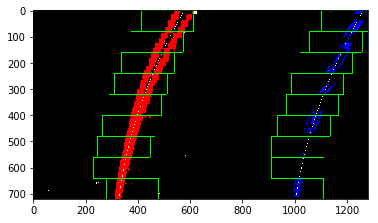

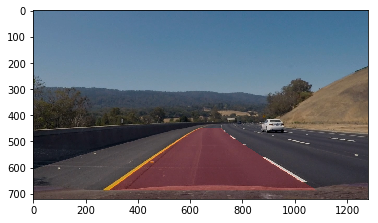

In [56]:
testImages = getImagesFromDirectory('test_images')
image = testImages[4]
displayImage(imagePipeline(image, resetLines=True, debug=True))

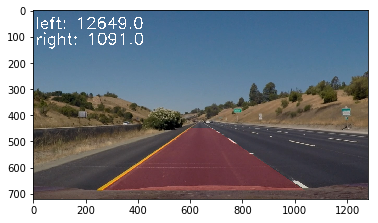

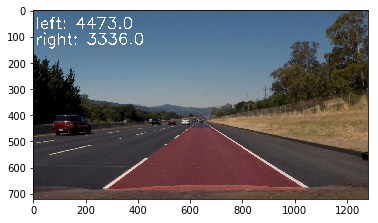

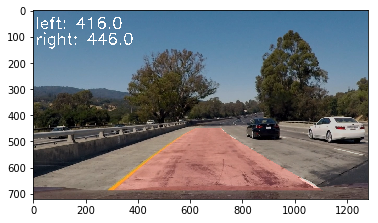

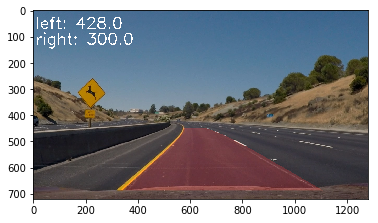

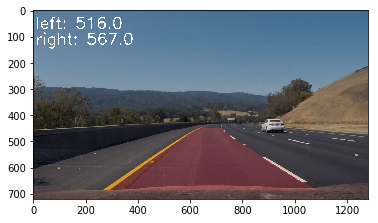

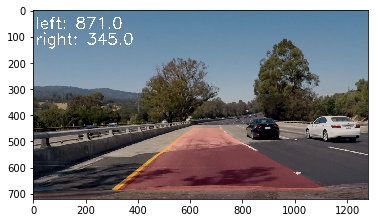

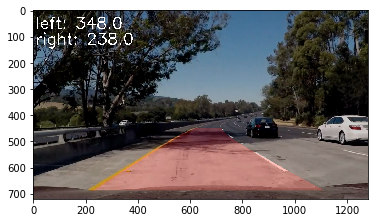

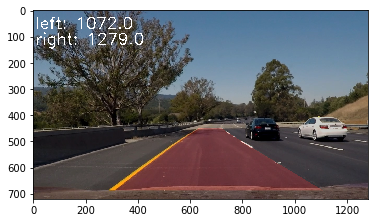

In [52]:
for image in testImages:
    displayImage(imagePipeline(image, resetLines=True, debug=False))

In [39]:
leftLine = Line('left')
rightLine = Line('right')

videoOutput = 'output_images/video.mp4'
clip = VideoFileClip('project_video.mp4')#.subclip(38,42.5)
videoWithLines = clip.fl_image(imagePipeline)
%time videoWithLines.write_videofile(videoOutput, audio=False)

[MoviePy] >>>> Building video output_images/video.mp4
[MoviePy] Writing video output_images/video.mp4


100%|█████████▉| 1260/1261 [03:28<00:00,  6.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video.mp4 

CPU times: user 3min 52s, sys: 29 s, total: 4min 21s
Wall time: 3min 30s


In [ ]:
#for t in np.arange(42.0, 43.0, 0.1):
#clip.save_frame('video_frames/videoFrame'+str(0)+'.png', 0)

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(videoOutput))

In [ ]:
leftLine = Line('left')
rightLine = Line('right')

videoOutput = 'output_images/challenge_video.mp4'
clip2 = VideoFileClip('challenge_video.mp4')#.subclip(41,43)
videoWithLines = clip2.fl_image(imagePipeline)
%time videoWithLines.write_videofile(videoOutput, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(videoOutput))